In [19]:
import numpy as np
import pandas as pd
import os
from torch.nn import Module, Conv2d, Linear, Dropout2d, LeakyReLU, BCELoss, BCEWithLogitsLoss, Flatten, CrossEntropyLoss, Softmax, BatchNorm2d, Dropout, Sequential
import torch
from torch.autograd import Variable
from torch.optim import AdamW, SGD, Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import h5py


In [30]:
train = h5py.File('../seti-breakthrough-listen/train_preprocessed/0.h5')

In [42]:
train['figure'].shape[1] * train['figure'].shape[2]

819

In [36]:
test = np.array(train['figure']).reshape(3713, 3*273, 256)

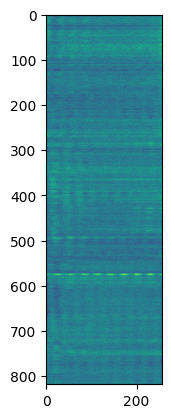

In [38]:
test.shape
for each in test:
    plt.imshow(each)
    break

In [34]:
train['figure'][0].shape

(3, 273, 256)

In [6]:
#normalize training images between [0,1]
normalizedTrain = []
for each in train['figure']:
    # plt.imshow(each.reshape(-1,256))
    cadences = []
    for cadence in each: 
        imNorm = (cadence - np.min(cadence))/(np.max(cadence) - np.min(cadence))
        imNorm = imNorm.astype('float32')
        cadences.append(imNorm)
    normalizedTrain.append(cadences)
normalizedTrain = np.array(normalizedTrain, dtype='float32')

In [29]:
normalizedTrain.shape[-1]

256

In [8]:
#get a train set where the figures are all in one just in case
flattenedTrain = []
for each in normalizedTrain:
    test = each.reshape(-1, 256)
    flattenedTrain.append(test)
flattenedTrain = np.array(flattenedTrain)

In [9]:
flattenedTrain.shape

(3713, 819, 256)

In [10]:
train_y = np.array(train['target'][:])

In [11]:
len(train_y)

3713

In [13]:
train_x, val_x, train_y, val_y = train_test_split(flattenedTrain, train_y, test_size=0.1)

In [14]:
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((3341, 819, 256), (3341,)), ((372, 819, 256), (372,)))

In [30]:
#convert train labels and features into torch format
train_x = train_x.reshape(3341, 1, 819, 256)
train_x = torch.from_numpy(train_x)
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape


(torch.Size([3341, 1, 819, 256]), torch.Size([3341]))

In [31]:
#same for validation
val_x.reshape(372, 1, 819, 256)
val_x  = torch.from_numpy(val_x)
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([372, 819, 256]), torch.Size([372]))

In [2]:
#simple neural net setup with 2 layers -- after running Optuna, will determine the ideal setup
class Net(Module):   
    def __init__(self, activation):
        super(Net, self).__init__()
        self.conv1 = Conv2d(1, 32, 3, 1)
        self.conv2 = Conv2d(32, 64, 3, 1)
        self.dropout1 = Dropout2d(0.25)
        self.dropout2 = Dropout2d(0.5)
        self.fc1 = Linear(9216, 128)
        self.fc2 = Linear(128, 10)
        self.activation = activation 

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    #     self.cnn_layers = Sequential(
    #         # Defining a 2D convolution layer
    #         Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
    #         BatchNorm2d(4),
    #         LeakyReLU(inplace=True),
    #         MaxPool2d(kernel_size=2, stride=2),
    #         # Defining another 2D convolution layer
    #         Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
    #         BatchNorm2d(4),
    #         LeakyReLU(inplace=True),
    #         MaxPool2d(kernel_size=2, stride=2),
    #     )

    #     self.linear_layers = Sequential(
    #         Linear(17408, 2)
    #     )

    # # Defining the forward pass    
    # def forward(self, x):
    #     x = self.cnn_layers(x)
    #     x = x.view(x.size(0), -1)
    #     x = self.linear_layers(x)
    #     return x

In [24]:
class TrainDataset(Dataset):
    def __init__(self, h5container, transform=None):
        self.file = h5container
        self.transform = transform
        self.image = np.array(self.file['figure'], dtype='float32')
        self.target = np.array(self.file['target'], dtype='int')

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, index):
        currImage = self.image[index].reshape(-1,256)
        currTarget = self.target[index]

        if self.transform is not None:
            currImage = self.transform(currImage)
        
        return torch.tensor(currImage), torch.tensor(currTarget)

In [25]:
train_dataset = TrainDataset(train)

In [28]:
train_x.shape[0]

3341

In [ ]:
def train(log_interval, model, trainx, trainy, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(trainx):
        optimizer.zero_grad()
        output = model(data.to(device))
        target = trainy[batch_idx]
        loss = F.binary_cross_entropy_with_logits(input, target)

In [33]:
model = Net()
optimizer = AdamW(model.parameters(), lr=0.05) #we will set lr after optuna
criterion = BCEWithLogitsLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=17408, out_features=2, bias=True)
  )
)


In [34]:
def train(epoch):
    model.train()
    tr_loss=0
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_val, y_val = Variable(val_x), Variable(val_y)
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    
    #clear gradients of parameters
    optimizer.zero_grad()

    #predictions
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)


In [35]:
n_epochs = 25
#these should be global
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train(epoch)

: 

: 